# Clean LSTM forecast code

## Import Data

### Libraries

In [1]:
import pyodbc
import pandas as pd
from math import floor
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot as plt
import numpy as np # linear algebra
from scipy.stats import randint
#import winsound

import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
import datetime as dt

#swap out for model_selection
#from sklearn.cross_validation import KFold # use for cross validation

from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error


## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

##default plot size (10 x 5)
plt.rcParams['figure.figsize'] = [10, 5]

#winsound.Beep(8000,10)

Using TensorFlow backend.


### Read in Data

In [2]:
#Set server location
server = 'x'
#Set db name
db = 'y'
#Run connection string
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + server + ';DATABASE=' + db + ';Trusted_Connection=yes;Integrated Security=SSPI')
#Read in data from SQL into pandas dataframe
date_data = pd.read_sql_query(sql='select * from table',
                               con=conn,
                               index_col='Date',
                               parse_dates=['Date'])
#Close connection
conn.close()



#Get Column name
colname = date_data.columns.values.tolist()
colname = colname[0]

### Split df by label

When data is in the following format (ie: multiple ts in a single table):
[date] [y] [Sta6a]
Use the code below to split and run on individual locations.

In [3]:
def df_splitter(date_data):
    df_dict = dict()
    date_data['colFromIndex'] = date_data.index
    date_data = date_data.sort_values(['location','colFromIndex'])
    date_data = date_data.drop(['colFromIndex'],axis=1)

    unique_labels = date_data.drop_duplicates(subset=['location'], keep='first')
    unique_labels = unique_labels['location'].tolist()
    unique_labels

    for label in unique_labels:
        df = date_data.loc[date_data['location']==label]
        df = df.drop(['location'],axis=1)
        df_dict[label] = df
    return(df_dict)

df_dict = df_splitter(date_data)

In [4]:
#df_dict.keys()
date_data = df_dict['location_name']
date_data.head()

,y
Date,
2016-11-01,10
2016-11-02,6
2016-11-03,10
2016-11-04,14
2016-11-07,5


## Transform

### Fill out days (puts zeros in missing days) and add a day function

In [5]:
def fill_out_dates(date_data):
    all_days = pd.date_range(start=min(date_data.index), end=max(date_data.index))
    all_days = pd.DataFrame(all_days)

    all_days.columns = ['Date']
    all_days['WEEKDAY'] = all_days['Date'].dt.dayofweek
    all_days.set_index('Date', inplace=True)

    df = all_days.join(date_data,how='left')#,lsuffix='_left',rsuffix='_right')
    date_data = df.fillna(0)

    date_data2 = date_data.copy(deep=True)
    date_data2= date_data2.drop('WEEKDAY',axis=1)
    return(date_data2)

date_data2 = fill_out_dates(date_data=date_data)

def add_a_day(date_data):
    all_days = pd.date_range(start=min(date_data.index), end=max(date_data.index))+dt.timedelta(days=1)
    all_days = pd.DataFrame(all_days)
    all_days.columns = ['Date']
    all_days.set_index('Date', inplace=True)
    df = all_days.join(date_data,how='left')#,lsuffix='_left',rsuffix='_right')
    date_data = df.fillna(0)
    date_data2 = date_data.copy(deep=True)
    return(date_data2)

### Runs an ACF and pulls the top 7 terms (by default)

In [6]:
#run ACF for first 40 terms--can be extended to n terms as needed
set_acf = acf(date_data2)

#returns the position of the top 7 terms (can be extended to n terms as needed)
def extract_lag(set_acf,n):
    '''
    Glue code to extract the most highly correlated ts n lags from the set.
    Returns a list of lags.
    '''
    temp_index = list()
    for i in range(0,len(set_acf)):
        temp_index.append(i)
    
    temp_index = np.array(temp_index)
    temp_index = temp_index.reshape(len(temp_index),1)
    set_acf = set_acf.reshape(len(set_acf),1)

    x = np.concatenate((temp_index,set_acf), axis = 1)
    x = x[1:,:]
    x = pd.DataFrame(x,columns=('index','acf'))
    x = x.sort_values(by=['acf'],ascending=False)

    lag_list = x.iloc[0:n,0]

    lag_list = lag_list.tolist()
    return(lag_list)

lag_list = extract_lag(set_acf,7)

### Transforms data into LSTM friendly format

By default this pulls 65% for train/val and the remainder for testing. 

In [7]:
def series_to_supervised(data, lag_list, dropnan=True):
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    #runs through lags in lag list and returns shifted columns
    for i in lag_list:
        cols.append(dff.shift(int(i)))
        names.append('t-%d' % (int(i)))
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    agg = agg.join(dff,how='left')
    #add in day of week marker
    #agg= agg.join(date_data.WEEKDAY,how='left')
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def prep_data(set, n_train):
    values = set.values
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled,lag_list, dropnan=True)
    
    reframed['y']=reframed[0]
    reframed.drop([0],axis=1,inplace=True)
    
    values = reframed.values
    
    train, test = values[:n_train, :], values[n_train:,:]
    return(scaler, train, test)

#prep_data(date_data, 365*3)
scaler, train, test = prep_data(date_data2, floor(len(date_data2)*.35))

def split_3d(train,test):
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return(train_X, train_y, test_X, test_y)

#split and reshape (lstms expect 3d inputs)
train_X, train_y, test_X, test_y = split_3d(train, test)

## LSTM Settings

These are some reasonable settings to start. You can achieve an improved fit by running the grid search function below.

In [8]:
dropout = 0.5
#0.2
cells = 120
#50
epochs = 80
batch_size = 100
#80
print_convergence = 0
loss = 'mean_squared_error'
optimizer = 'adam'
n_times = 60

This is an initial train and fit iteration. Feed forward and prediction occurs below.

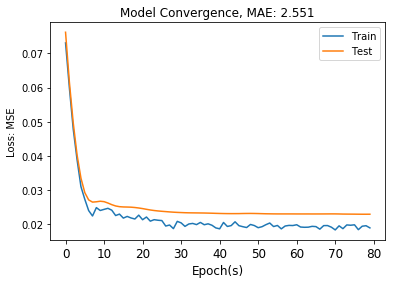

In [9]:
#wrapper for lstm
def fit_lstm(train_X, train_y,test_X, test_y,dropout, cells, epochs, batch_size, print_convergence, loss, optimizer):
    model = Sequential()
    model.add(LSTM(cells, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer)
    #stopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, 
                    validation_data=(test_X, test_y), verbose=print_convergence, shuffle=False)
    return(model, history)

#fit model
model, history = fit_lstm(train_X = train_X, train_y = train_y,
                          test_X = test_X, test_y = test_y,
                          dropout = dropout, cells = cells, 
                          epochs = epochs, batch_size = batch_size, 
                          print_convergence = print_convergence,
                          loss = loss, optimizer = optimizer)

#model fit stat against test data
def model_summary(model, test_X, test_y):
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], 7))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate mae
    mae = mean_absolute_error(inv_y, inv_yhat)
    return(round(mae, 3))
    
model_mae = model_summary(model = model, test_X = test_X, test_y = test_y)

#plot descent history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Convergence, MAE: {}'.format(model_mae))
plt.ylabel('Loss: MSE')
plt.xlabel('Epoch(s)', size = 12)
plt.xticks(size=12)
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Optional: Model Tuning / Hyperparameter gridsearch

These are fairly course grain pass through hyperparameters for gridseach iteration. You can fine tune as you are interested/motivated.

In [14]:
#This is a fairly course grain pass through of hyperparameter values of interest.
grid_params = {'batch_size' : [10, 20, 40, 60, 80, 100],
                  'epochs' : [10, 30, 60, 80],
                  'cells' : [1, 5, 10, 30, 50, 80, 120],
                  'dropout' : [.0, .1, .2, .3, .4, .5]}

#additional parameters for grid search that are not currently implemented (too little benefit)
#activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#optimizer = SGD(lr=learn_rate, momentum=momentum)

This can take some time, so run this if you want to squeeze additional performance. Small sets for this grid search can take 5 minutes a pop. It will push out a dictionary of best hyperparameters. Uncomment the function call at the end to run gridsearch.

In [15]:
def grid_searcher(grid_params):
    import inspect
    output = dict()
    for key, value in grid_params.items():
        #arbitrarily high mae setting
        model_mae = 100
        for i in value:
            dropout = 0.2
            cells = 50
            epochs = 80
            batch_size = 80
            if key == 'batch_size':
                batch_size = i
            elif key == 'epochs':
                epochs = i
            elif key == 'cells':
                cells = i
            elif key == 'dropout':
                dropout = i
            model, history = fit_lstm(train_X = train_X, train_y = train_y,
                              test_X = test_X, test_y = test_y,
                              dropout = dropout, cells = cells, 
                              epochs = epochs, batch_size = batch_size, 
                              print_convergence = print_convergence,
                              loss = loss, optimizer = optimizer)
            model_mae_1 = model_summary(model = model, test_X = test_X, test_y = test_y)
            if model_mae_1 < model_mae:
                output['best{}'.format(key)] = i
    return(output)

#grid_searcher(grid_params = grid_params)

KeyboardInterrupt: 

### Model introspection

This function call requires graphviz to be installed on your computer, but it will generate a graph visualization of the network as designed. Uncomment the last line to generate the plot.

In [ ]:
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

from keras.utils import plot_model
#plot_model(model, to_file='model.png')

### Model fit

# Train and feed forward

Call lstm_ntimes with your choice of n for predictions n periods into the future. By default this predicts 60 days into the future.

In [10]:
def dayout(model, test_X, test_y, date_source):
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], 7))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    df = pd.pandas.DataFrame(inv_yhat, date_source.index[len(date_source)-len(inv_yhat):],columns = ['y'])
    return(df.tail(1))

def lstm_ntimes(data,n_times):
    temp_data = fill_out_dates(data)
    for i in range(n_times):
        date_data2 = add_a_day(temp_data)
        scaler, train, test = prep_data(date_data2, floor(len(date_data2)*.35))
        train_X, train_y, test_X, test_y = split_3d(train, test)
        x = dayout(model=model, test_X = test_X, test_y = test_y, date_source = date_data2)
        #print(x)
        #date_data2= date_data2.append(x)
        
        temp_data = temp_data.append(x)
        #print(date_data2.tail(1))
    return(temp_data)

x = lstm_ntimes(date_data, n_times)

## Results

### Plot Forecast

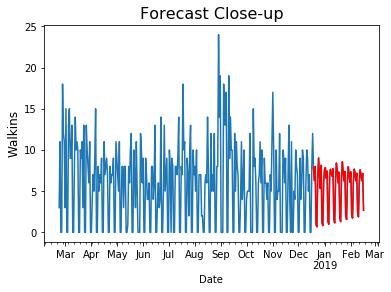

In [11]:
ax = x.tail(n_times+300).plot()
#ax = x.plot()
x.loc[x.index>= x.index[-n_times]].plot(color='r', ax = ax)
plt.title('Forecast Close-up', size = 16)
plt.ylabel('Walkins',size=12)
ax.legend_.remove()
plt.show()

### Print Forecast

In [12]:
x.tail(60)
#x.to_csv('648lstmout.csv')

,y
Date,
2018-12-19,7.868543
2018-12-20,6.275144
2018-12-21,7.981305
2018-12-22,0.943259
2018-12-23,0.667426
2018-12-24,6.669584
2018-12-25,9.036218
2018-12-26,6.965288
2018-12-27,5.326495
